<a href="https://colab.research.google.com/github/11kartheek/clip-sam/blob/main/clip_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install torch torchvision transformers
!pip -q install open_clip_torch
!pip -q install datasets[vision]
!pip -q install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-fra

In [2]:
import open_clip
import torch
import gradio as gr
from PIL import Image
from datasets import load_dataset
from datasets import load_from_disk

import random

# Load the fruits dataset
dataset = load_dataset("VinayHajare/Fruits-30")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/827 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/826 [00:00<?, ? examples/s]

In [3]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [4]:
dataset.save_to_disk("./fruits_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/826 [00:00<?, ? examples/s]

In [5]:
from huggingface_hub import HfApi
api = HfApi()

In [6]:
from huggingface_hub import login
login()

In [8]:
# api.upload_folder(
#     folder_path="fruits_dataset",
#     repo_id="Kartheekb7/clip_classification",
#     repo_type="space",
# )

In [15]:
from datasets import load_from_disk
dataset = load_from_disk("./fruits_dataset/train/train")

In [16]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 826
})

In [17]:
from collections import OrderedDict

FRUITS30_CLASSES = OrderedDict(
    {
           "0" : "acerolas",
           "1" : "apples",
           "2" : "apricots",
           "3" : "avocados",
           "4" : "bananas",
           "5" : "blackberries",
           "6" : "blueberries",
           "7" : "cantaloupes",
           "8" : "cherries",
           "9" : "coconuts",
           "10" : "figs",
           "11" : "grapefruits",
           "12" : "grapes",
           "13" : "guava",
           "14" : "kiwifruit",
           "15" : "lemons",
           "16" : "limes",
           "17" : "mangos",
           "18" : "olives",
           "19" : "oranges",
           "20" : "passionfruit",
           "21" : "peaches",
           "22" : "pears",
           "23" : "pineapples",
           "24" : "plums",
           "25" : "pomegranates",
           "26" : "raspberries",
           "27" : "strawberries",
           "28" : "tomatoes",
           "29" : "watermelons"
    }
)

In [12]:
labels = list(FRUITS30_CLASSES.values())

In [13]:


# Function to pick three random sets and shuffle labels
def prepare_game():
    # Pick 3 random indices
    indices = random.sample(range(len(dataset)), 1)

    # Get images and their corresponding labels
    selected_images = [dataset[i]['image'] for i in indices]

    return selected_images[0]



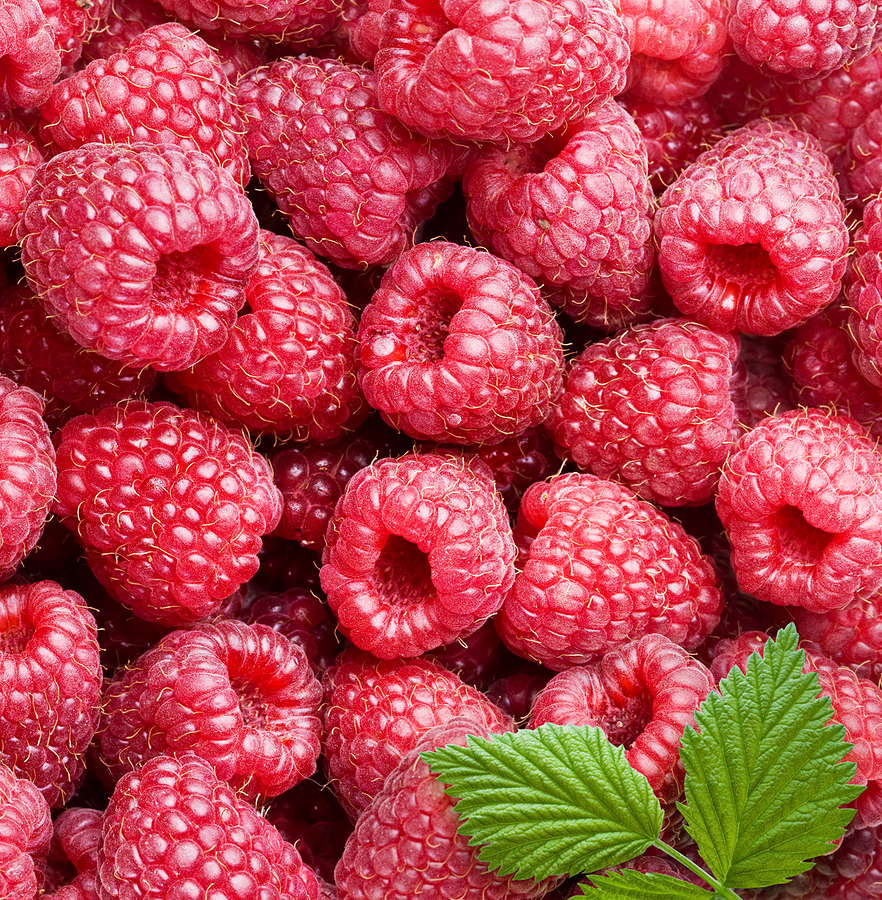

In [18]:
img = prepare_game()
img

In [19]:
def on_submit(img1,label1):
        image = preprocess(img1).unsqueeze(0)
        text = tokenizer(labels+[label1,"not a fruit"])

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        correct_label = FRUITS30_CLASSES[str(text_probs.argmax().item())]
        return correct_label

In [20]:
on_submit(img,'dog')

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


'raspberries'

In [23]:
def create_interface():
    # Store current correct labels in a mutable container
    current_correct_labels = []

    def get_image():
        indices = random.sample(range(len(dataset)), 1)
        selected_images = [dataset[i]['image'] for i in indices]
        return selected_images[0]

    def on_submit(img1,label1):
        image = preprocess(img1).unsqueeze(0)
        text = tokenizer(labels+[label1,"not a fruit"])

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        correct_label = FRUITS30_CLASSES[str(text_probs.argmax().item())]
        return correct_label

    with gr.Blocks() as demo:
        # Create components
        with gr.Row():
          img1 = gr.Image(type="pil", label="Fruit",height = 400,width = 400)
        with gr.Row():
          label1 = gr.Textbox(label="Name this fruit")

        submit_btn = gr.Button("Submit")
        refresh_btn = gr.Button("Refresh")

        result = gr.Textbox(label="Answer")

        # Update images, labels, and correct labels on refresh button click
        refresh_btn.click(
            fn=get_image,
            outputs=[img1]
        )


        # Evaluate user input on submit button click
        submit_btn.click(
            fn=on_submit,
            inputs=[img1,label1],
            outputs=result
        )

    demo.launch()

# Run the game
create_interface()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4ea20a04eecdb732ff.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [29]:
import open_clip
import torch
import gradio as gr
from PIL import Image
from datasets import load_dataset
import random
from datasets import load_from_disk
dataset = load_from_disk("./fruits_dataset/train/train")
from collections import OrderedDict
FRUITS30_CLASSES = OrderedDict(
    {
           "0" : "acerolas",
           "1" : "apples",
           "2" : "apricots",
           "3" : "avocados",
           "4" : "bananas",
           "5" : "blackberries",
           "6" : "blueberries",
           "7" : "cantaloupes",
           "8" : "cherries",
           "9" : "coconuts",
           "10" : "figs",
           "11" : "grapefruits",
           "12" : "grapes",
           "13" : "guava",
           "14" : "kiwifruit",
           "15" : "lemons",
           "16" : "limes",
           "17" : "mangos",
           "18" : "olives",
           "19" : "oranges",
           "20" : "passionfruit",
           "21" : "peaches",
           "22" : "pears",
           "23" : "pineapples",
           "24" : "plums",
           "25" : "pomegranates",
           "26" : "raspberries",
           "27" : "strawberries",
           "28" : "tomatoes",
           "29" : "watermelons"
    }
)
labels = list(FRUITS30_CLASSES.values())
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

def create_interface():
    # Store current correct labels in a mutable container
    current_correct_labels = []
    def get_image():
        indices = random.sample(range(len(dataset)), 1)
        selected_images = [dataset[i]['image'] for i in indices]
        return selected_images[0]

    def on_submit(img1,label1):
        image = preprocess(img1).unsqueeze(0)
        text = tokenizer(labels+[label1,"not a fruit"])

        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        correct_label = FRUITS30_CLASSES[str(text_probs.argmax().item())]
        return correct_label

    with gr.Blocks() as demo:
        # Create components
        with gr.Row():
          img1 = gr.Image(type="pil", label="Fruit",height = 300,width = 300)
          label1 = gr.Textbox(label="Name this fruit")

        submit_btn = gr.Button("Submit")
        refresh_btn = gr.Button("Refresh")

        result = gr.Textbox(label="Answer")

        # Update images, labels, and correct labels on refresh button click
        refresh_btn.click(
            fn=get_image,
            outputs=[img1]
        )
        # Evaluate user input on submit button click
        submit_btn.click(
            fn=on_submit,
            inputs=[img1,label1],
            outputs=result
        )

    demo.launch(debug = True)

# Run the game
create_interface()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://eb77342fdfe942c448.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7863 <> https://eb77342fdfe942c448.gradio.live
